# Recommendations for Potential Folk/Country Artists to Achieve Top Ratings on Pitchfork

Our statistical analysis is centered on the question, what can a potential folk/country artist do to achive top ratings and get best new music on Pitchfork? To answer this question, we did some exploratory data analysis and conducted the the following hypotheses. 
* Is there a statistical difference between the scores of folk/country and metal genres?
* Is there a difference between the scores of folk/country and all other music genres?
* Is there a difference between the average of best new music awards for each label?
* Is there a difference between the average scores given by author reviews for folk/country music?
* Is there a difference between the average scores of folk country music for each label?

Below is the entity relationship diagram for our database.

## Setting Up Database and Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import psycopg2
import pandas.io.sql as psql
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import ttest_ind
from statsmodels.stats.power import TTestIndPower

%matplotlib inline

In [2]:
# Create a connection to the database
conn = psycopg2.connect("dbname=pitchfork")
cur = conn.cursor()

## Exploratory Data Analysis

To orient, conduct exploratory queries. Look at table names, columns, and visualize in dataframes.

In [3]:
query_tables_and_columns = """ SELECT table_name, column_name
FROM information_schema.columns
WHERE table_schema= 'public'
ORDER BY table_name, column_name;"""

In [4]:
cur.execute(query_tables_and_columns)

In [5]:
cur.fetchall()

[('artists', 'artist'),
 ('artists', 'id'),
 ('artists', 'reviewid'),
 ('content', 'content'),
 ('content', 'reviewid'),
 ('genres', 'genre'),
 ('genres', 'reviewid'),
 ('labels', 'label'),
 ('labels', 'reviewid'),
 ('reviews', 'artist'),
 ('reviews', 'author'),
 ('reviews', 'author_type'),
 ('reviews', 'best_new_music'),
 ('reviews', 'pub_date'),
 ('reviews', 'pub_day'),
 ('reviews', 'pub_month'),
 ('reviews', 'pub_weekday'),
 ('reviews', 'pub_year'),
 ('reviews', 'reviewid'),
 ('reviews', 'score'),
 ('reviews', 'title'),
 ('reviews', 'url'),
 ('years', 'reviewid'),
 ('years', 'year')]

In [6]:
# Create artists dataframe
df_artists = psql.read_sql("SELECT * FROM artists;", conn)
df_artists.head()

,reviewid,artist,id
0,22703,massive attack,1
1,22721,krallice,2
2,22659,uranium club,3
3,22661,kleenex,4
4,22661,liliput,5


In [7]:
# Create content dataframe
df_content = psql.read_sql("SELECT * FROM content;", conn)
df_content.head()

,reviewid,content
0,22703,"“Trip-hop” eventually became a ’90s punchline,..."
1,22721,"Eight years, five albums, and two EPs in, the ..."
2,22659,Minneapolis’ Uranium Club seem to revel in bei...
3,22661,Kleenex began with a crash. It transpired one ...
4,22725,It is impossible to consider a given release b...


In [8]:
# Create genres dataframe
df_genres = psql.read_sql("SELECT * FROM genres;", conn)
df_genres.head()

,reviewid,genre
0,22703,electronic
1,22721,metal
2,22659,rock
3,22661,rock
4,22725,electronic


In [9]:
df_genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22680 entries, 0 to 22679
Data columns (total 2 columns):
reviewid    22680 non-null int64
genre       20313 non-null object
dtypes: int64(1), object(1)
memory usage: 354.5+ KB


There are ~2000 entries with no genre listed, or music that is perhaps, 'genre-defying.' Choose to assume the latter and convert nulls to no_genre. 

In [10]:
df_genres['genre'].fillna('no_genre', inplace=True)

In [11]:
# Create labels dataframe
df_labels = psql.read_sql("SELECT * FROM labels;", conn)
df_labels.head()

,reviewid,label
0,22703,virgin
1,22721,hathenter
2,22659,static shock
3,22659,fashionable idiots
4,22661,kill rock stars


In [12]:
# Create reviews dataframe
df_reviews = psql.read_sql("SELECT * FROM reviews;", conn)
df_reviews.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017
3,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017
4,22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017


In [13]:
# Create years dataframe
df_years = psql.read_sql("SELECT * FROM years", conn)
df_years.head()

,reviewid,year
0,22703,1998.0
1,22721,2016.0
2,22659,2016.0
3,22661,2016.0
4,22725,2016.0


In [14]:
# dataframe of genres and scores
cur.execute("""SELECT score, genre FROM reviews 
            JOIN genres 
            ON reviews.reviewid = genres.reviewid
            ;""")
df_genre_scores = pd.DataFrame(cur.fetchall())
df_genre_scores.columns = [i[0] for i in cur.description]

Change null values to 'no_genre'.

In [15]:
df_genre_scores['genre'].fillna('no_genre', inplace=True)

In [16]:
df_genre_scores.head()

,score,genre
0,9.3,electronic
1,7.9,metal
2,7.3,rock
3,9.0,rock
4,8.1,electronic


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


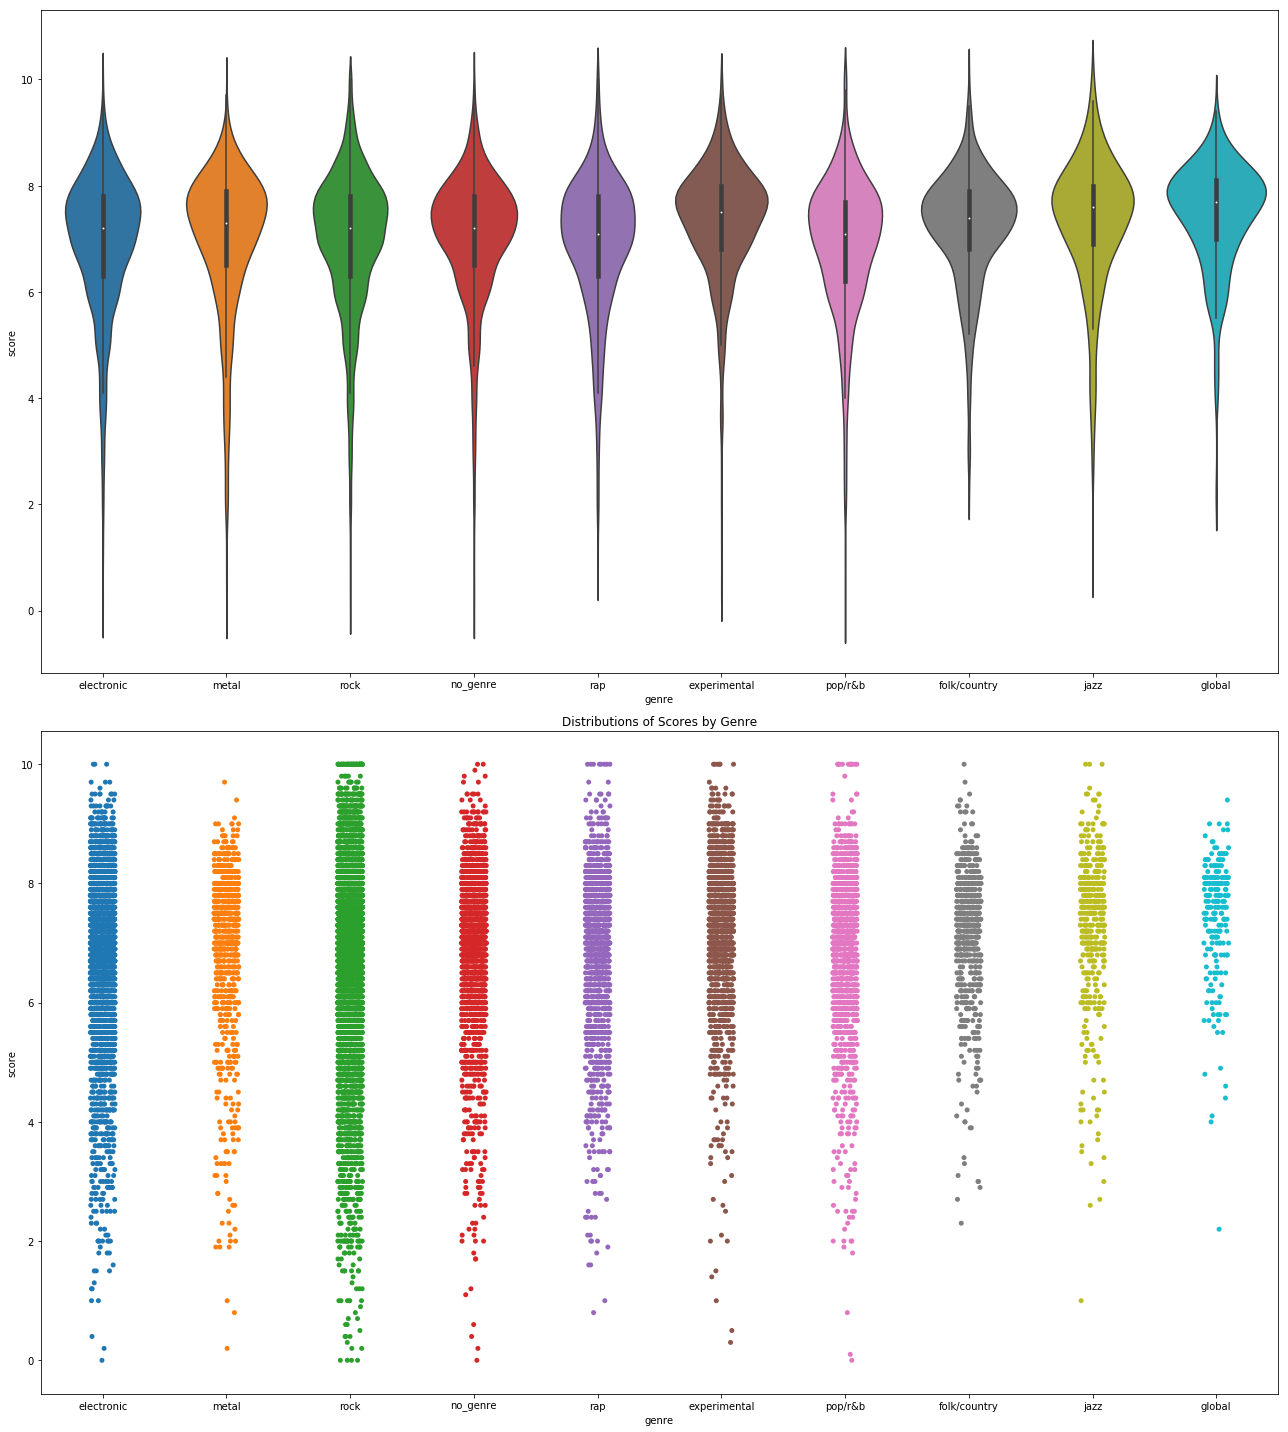

In [17]:
# Visualize distributions of scores by genre

f, axes = plt.subplots(2, 1, figsize = (18, 20))
plt.title("Distributions of Scores by Genre")
sns.violinplot(x="genre", y="score", data=df_genre_scores, ax = axes[0])
sns.stripplot(x="genre", y="score", data=df_genre_scores, ax = axes[1])
plt.tight_layout()

Notice that the mean values and kernel densities look similar across the genres.

## Question 1: Is there a statistical difference between the scores of folk/country and metal genres?

Null hypothesis: There is no difference between the mean score of folk/country and metal genres. <br>
Alternative Hypothesis: There is a difference between the mean score of folk/country and metal genres.

In [18]:
# Create dataframe for folk/country and scores
is_folk = df_genre_scores['genre']== 'folk/country'
folk_scores = df_genre_scores.loc[is_folk]
folk_scores.head()

,score,genre
28,6.8,folk/country
78,7.8,folk/country
127,7.3,folk/country
147,8.5,folk/country
152,7.8,folk/country


In [19]:
folk_scores.describe()

,score
count,685.000000
mean,7.202190
std,1.064435
min,2.300000
25%,6.800000
50%,7.400000
75%,7.900000
max,10.000000


In [20]:
# Create dataframe for metal and scores
is_metal = df_genre_scores['genre'] == 'metal'
metal_scores = df_genre_scores.loc[is_metal]
metal_scores.head()

,score,genre
1,7.9,metal
22,7.5,metal
33,7.7,metal
124,6.5,metal
146,6.4,metal


In [21]:
metal_scores.describe()

,score
count,862.000000
mean,6.950000
std,1.387799
min,0.200000
25%,6.500000
50%,7.300000
75%,7.900000
max,9.700000


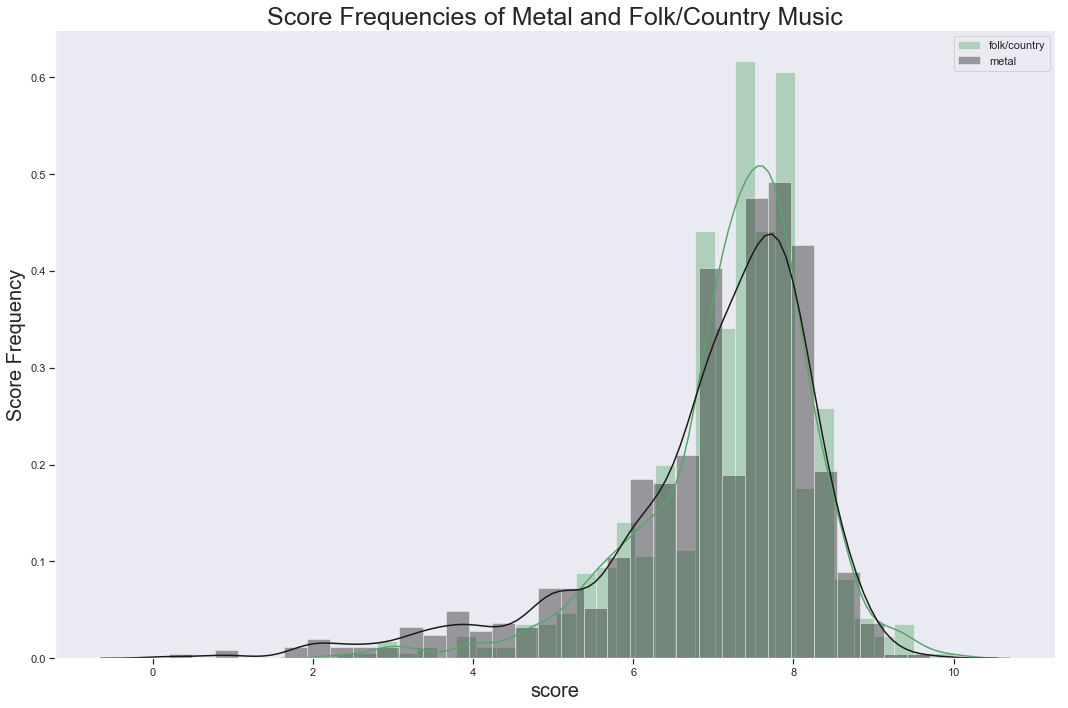

In [62]:
#Look at the distributions of scores for metal and folk/country genres
#futurewarning has to do with sns using scipy.stats for calculations, and will be addressed 
sns.set()
plt.figure(figsize=(15,10))
sns.set_style("dark", {"xtick.bottom":True, "ytick.left":True})
plt.xlabel('Score', fontsize='20')
plt.ylabel('Score Frequency', fontsize='20')
plt.title('Score Frequencies of Metal and Folk/Country Music', fontsize='25')
sns.distplot(folk_scores['score'], color='g', label='folk/country')
sns.distplot(metal_scores['score'], color='k', label='metal')
sns.despine()
plt.tight_layout()
plt.legend()
plt.show();

### Test Null Hypothesis. Assume p-value < 0.05 to reject null hypothesis. The standard deviations are different, thus the variances are different, so we'll set "equal_var=False" to use Welch's test.

In [66]:
ttest_ind(folk_scores['score'], metal_scores['score'], axis=0, equal_var=False)

Ttest_indResult(statistic=4.044303101957469, pvalue=5.507059645103283e-05)

The pvalue for this test, 0.0000507, is much smaller than our 0.05, rejecting the null hypothesis.

Now we check that we have enough samples for a large effect and a 95% confidence interval.

In [65]:
# Initialize parameters
effect = 0.8
alpha = 0.05
power = 0.8
# Size of folk/country scores sample to all other music sample
ratio = len(metal_scores) / len(folk_scores)
print(ratio)
# Perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power, nobs1=None,
                              ratio=ratio, alpha=alpha)
print(f"Minimum Sample Size: {result}")
print(f"Folk/Country Sample Size: {len(folk_scores)}")

1.2583941605839417
Minimum Sample Size: 22.891880051492222
Folk/Country Sample Size: 685


Our sample size is easily large enough. Let's look at how the power size would change given fewer samples:

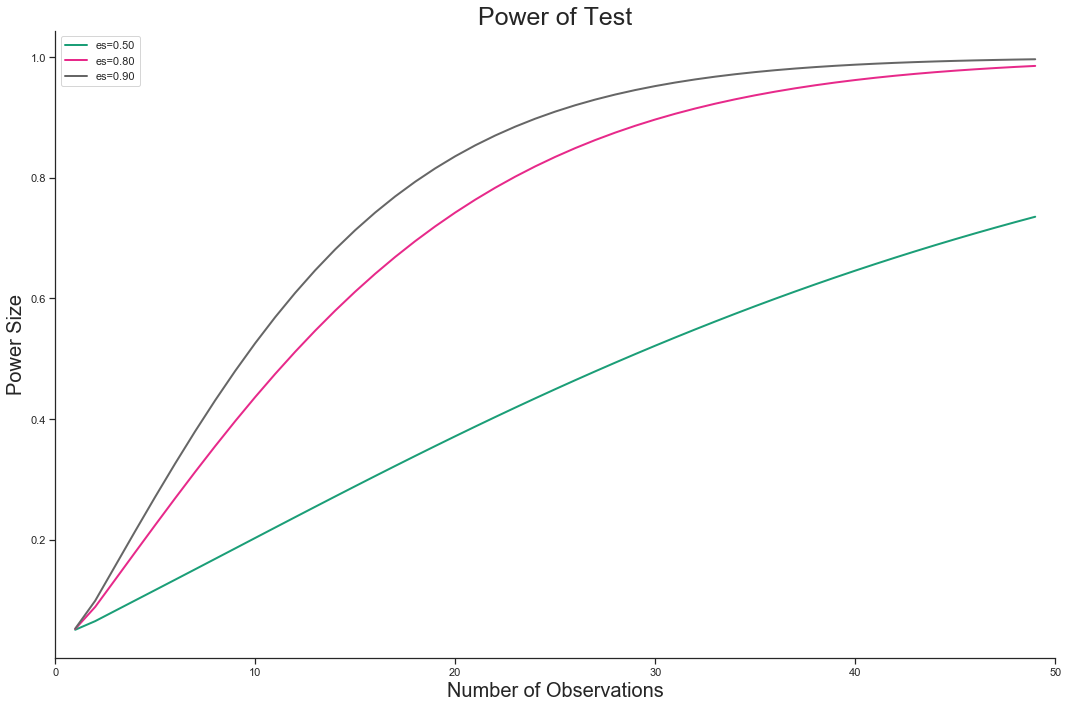

In [24]:
# parameters for power analysis
effect_sizes = np.array([0.5, 0.8, 0.9])
sample_sizes = np.array(range(1, 50))
# Calculate multiple power analysis curves
analysis = TTestIndPower()
sns.set()
sns.set_style("white", {"xtick.bottom":True, "ytick.left":True})
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)
ax = analysis.plot_power(dep_var='nobs', nobs=sample_sizes, ax=ax, ratio=ratio, effect_size=effect_sizes)
plt.xlabel('Number of Observations', fontsize='20')
plt.xlim(0, 50)
plt.ylabel('Power Size', fontsize='20')
plt.title('Power of Test', fontsize='25')
sns.despine()
plt.tight_layout()
plt.legend()
plt.show();

Based on the power analysis, we can accept results of the hypothesis test.

### We reject the null hypothesis in favor of the alternative hypothesis. There is a difference between mean scores of folk/country and metal genres.

## Question 1A: Does the folk/country genre receive higher scores than metal?

Null hypothesis: The mean score of folk/country is not larger than the mean score of metal genres. <br>
Alternative Hypothesis: The mean score of folk/country is larger than the mean score of metal genres.

This calls for a one-tailed test with p-value <0.025 to reject the null hypothesis.

In [67]:
ttest_ind(folk_scores['score'], metal_scores['score'], axis=0, equal_var=False)

Ttest_indResult(statistic=4.044303101957469, pvalue=5.507059645103283e-05)

The pvalue for this test, 0.0000507, is much smaller than our 0.05, rejecting the null hypothesis.

### We reject the null hypothesis. The mean score of folk/country is larger than the mean score of metal genres.

## Question 2: Is there a difference between the ratings of folk/country music and all other music?

Check unique list of genres. Include value counts.

In [25]:
query_unique_genres = """ SELECT genre, COUNT(genres)
FROM genres
GROUP BY genre;"""

In [26]:
cur.execute(query_unique_genres)

In [27]:
cur.fetchall()

[('global', 217),
 ('experimental', 1815),
 ('metal', 860),
 (None, 2367),
 ('electronic', 3874),
 ('folk/country', 685),
 ('pop/r&b', 1432),
 ('jazz', 435),
 ('rap', 1559),
 ('rock', 9436)]

Going with 'folk/country.' Reviews seem to be rated by 'score' and 'best new music.' Look at descriptive statistics and variances. Make distributions of 'folk/country' and all other music. 

In [28]:
og_df = df_genre_scores[df_genre_scores['genre'] != 'folk/country'].copy()

In [29]:
og_df.describe()

,score
count,22005.000000
mean,6.984585
std,1.311801
min,0.000000
25%,6.400000
50%,7.200000
75%,7.800000
max,10.000000


In [30]:
fc_var = np.var(folk_scores, ddof=1)
og_var = np.var(og_df, ddof=1)
fc_var[0], og_var[0]

(1.1330215136381085, 1.7208230931220514)

The variances are unequal and sizes unequal, do Welch's T-test.

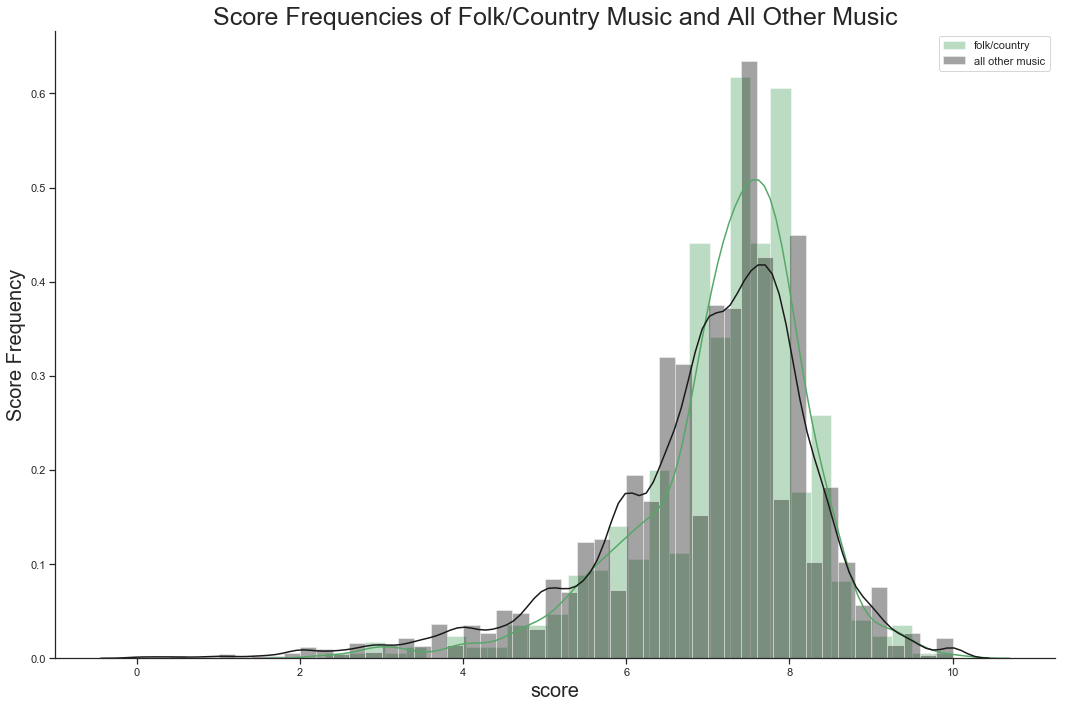

In [31]:
sns.set()
plt.figure(figsize=(15,10))
sns.set_style("white", {"xtick.bottom":True, "ytick.left":True})
plt.xlabel('Score', fontsize='20')
plt.ylabel('Score Frequency', fontsize='20')
plt.title('Score Frequencies of Folk/Country Music and All Other Music', fontsize='25')
sns.distplot(folk_scores['score'], color='g', label='folk/country')
sns.distplot(og_df['score'], color='k', label='all other music')
sns.despine()
plt.tight_layout()
plt.legend()
plt.show();

From a visual, it looks like there is little, if any, difference between folk/country ratings and all other music. To determine whether folk/country ratings or all other music ratings we use a Welch's T-Test to compare the average ratings for each sample. We also conduct a power analysis. By convention, significance level (alpha) is 0.05, effect size (Cohen's d measure) is at least 0.8, and statistical power is 0.8. Our hypotheses are: <br>
Null Hypothesis: The mean difference between review score for folk/country and all other music is zero. <br>
Alternative Hypothesis: The mean difference between review score folk/country and all other music is different from zero. <br>

In [32]:
# Use scipy.stats to conduct 2-sample t-test
ttest_ind(folk_scores['score'], og_df['score'], equal_var=False)

Ttest_indResult(statistic=5.228327988171849, pvalue=2.2201136243632232e-07)

The p-value is ~ 2.22, which is greater than 0.05. Not enough evidence to reject null hypothesis. There is no statistical difference in the average review scores between folk/country and all other music. <br> <br>
Next, do a power analysis to estimate a suitable sample size (how many observations needed for each sample) to detect an effect of 0.8 with an 80% chance of detecting the effect if it is true (so 20% false negatives) and a 5% chance of detecting an effect if there is no effect (false positives). 

In [33]:
# Initialize parameters
effect = 0.8
alpha = 0.05
power = 0.8
# Size of folk/country scores sample to all other music sample
ratio = len(folk_scores) / len(og_df)  
# Perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power, nobs1=None,
                             ratio=ratio, alpha=alpha)
print(f"Minimum Sample Size: {result}")
print(f"Folk/Country Sample Size:{len(folk_scores)}")

Minimum Sample Size: 408.09978349002654
Folk/Country Sample Size:685


The sample size of folk country is greater than the estimated sample size needed. Generate power curves, to visualize how effect changes with different sample sizes.

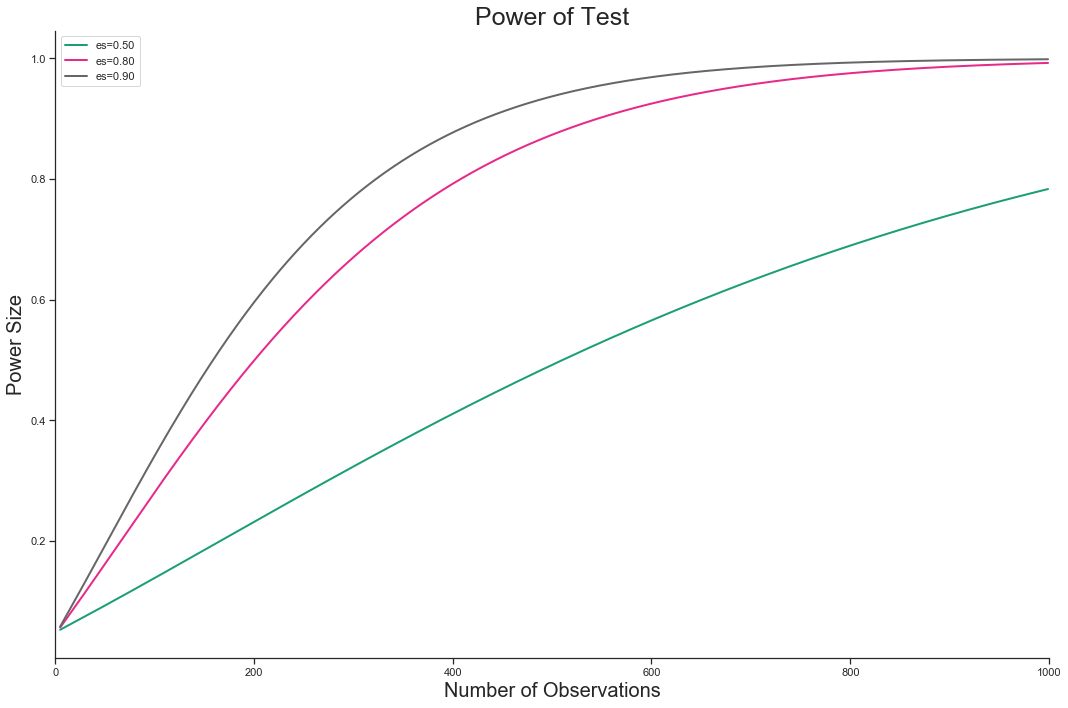

In [34]:
# parameters for power analysis
effect_sizes = np.array([0.5, 0.8, 0.9])
sample_sizes = np.array(range(5, 1000))
# Calculate multiple power analysis curves
analysis = TTestIndPower()
sns.set()
sns.set_style("white", {"xtick.bottom":True, "ytick.left":True})
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)
ax = analysis.plot_power(dep_var='nobs', nobs=sample_sizes, ax=ax, ratio=ratio, effect_size=effect_sizes)
plt.xlabel('Number of Observations', fontsize='20')
plt.xlim(0, 1000)
plt.ylabel('Power Size', fontsize='20')
plt.title('Power of Test', fontsize='25')
sns.despine()
plt.tight_layout()
plt.legend()
plt.show();

## Question 3: Do some labels produce a higher proportion of "Best New Music?"

Null hypothesis: There is no difference between the labels' percent of best_new_music. 
Alternative Hypothesis: There is a difference between the labels' percent of best_new_music. 

In [35]:
# dataframe of labels and total best_new_music values produced
cur.execute("""SELECT count(best_new_music) AS num_best_new_music, label, count(reviews.reviewid) AS times_reviewed 
            FROM reviews 
            JOIN labels 
            ON reviews.reviewid = labels.reviewid
            GROUP BY label, best_new_music
            HAVING  best_new_music = 1
            ;""")
df_labels_most_awards = pd.DataFrame(cur.fetchall())
df_labels_most_awards.columns = [i[0] for i in cur.description]
df_labels_most_awards.head()

,num_best_new_music,label,times_reviewed
0,1,gigantic,1
1,2,k,2
2,4,southern lord,4
3,1,xpressway,1
4,2,a&m,2


Let's take a look at the labels with an average of one "Best New Music" album.

In [52]:
cur.execute('''SELECT label, sum(best_new_music) AS num_best_new_music, 
            count(label) AS times_reviewed
            FROM reviews
            JOIN labels
            ON reviews.reviewid = labels.reviewid
            GROUP BY label''')
#create dataframe
df_label_counts_best = pd.DataFrame(cur.fetchall())
df_label_counts_best.columns = [i[0] for i in cur.description]

# df_label_counts_best = df_label_counts_best.sort_values(by=['num_best_new_music'], ascending=False)
df_label_counts_best.head()

,label,num_best_new_music,times_reviewed
0,stolen recordings,0,1
1,None,5,0
2,stress,0,1
3,day tripper,0,1
4,blue fog,0,1


In [53]:
df_label_counts_best.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3668 entries, 0 to 3667
Data columns (total 3 columns):
label                 3667 non-null object
num_best_new_music    3668 non-null object
times_reviewed        3668 non-null int64
dtypes: int64(1), object(2)
memory usage: 86.0+ KB


There are many, many labels. We'll look at the labels which have produced 6 or more "Best New Music" albums.

In [54]:
df_labels_most_best = df_label_counts_best[df_label_counts_best['num_best_new_music'] >= 6].copy()
#convert datatypes for division
df_labels_most_best['num_best_new_music'] = df_labels_most_best['num_best_new_music'].astype(int)
df_labels_most_best['times_reviewed'] = df_labels_most_best['times_reviewed'].astype(int)
df_labels_most_best.head()

,label,num_best_new_music,times_reviewed
28,astralwerks,6,153
56,kill rock stars,7,90
106,virgin,7,108
243,sub pop,32,268
246,carpark,7,59


In [57]:
#add column
df_labels_most_best['percent_best'] = 100*df_labels_most_best['num_best_new_music'] / df_labels_most_best['times_reviewed']
df_labels_most_best = df_labels_most_best.sort_values(by=['percent_best'], ascending=False)
df_labels_most_best

,label,num_best_new_music,times_reviewed,percent_best
685,roc-a-fella,8,20,40.000000
1216,4ad,31,126,24.603175
288,modular,6,26,23.076923
3031,true panther,7,31,22.580645
1202,legacy,12,54,22.222222
2563,light in the attic,12,57,21.052632
1367,strut,6,30,20.000000
986,universal,16,93,17.204301
2899,domino,36,211,17.061611
2790,hyperdub,7,43,16.279070


In [49]:
df_labels_most_best.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47 entries, 685 to 3428
Data columns (total 4 columns):
label                 47 non-null object
num_best_new_music    47 non-null int64
times_reviewed        47 non-null int64
percent_best          47 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.8+ KB


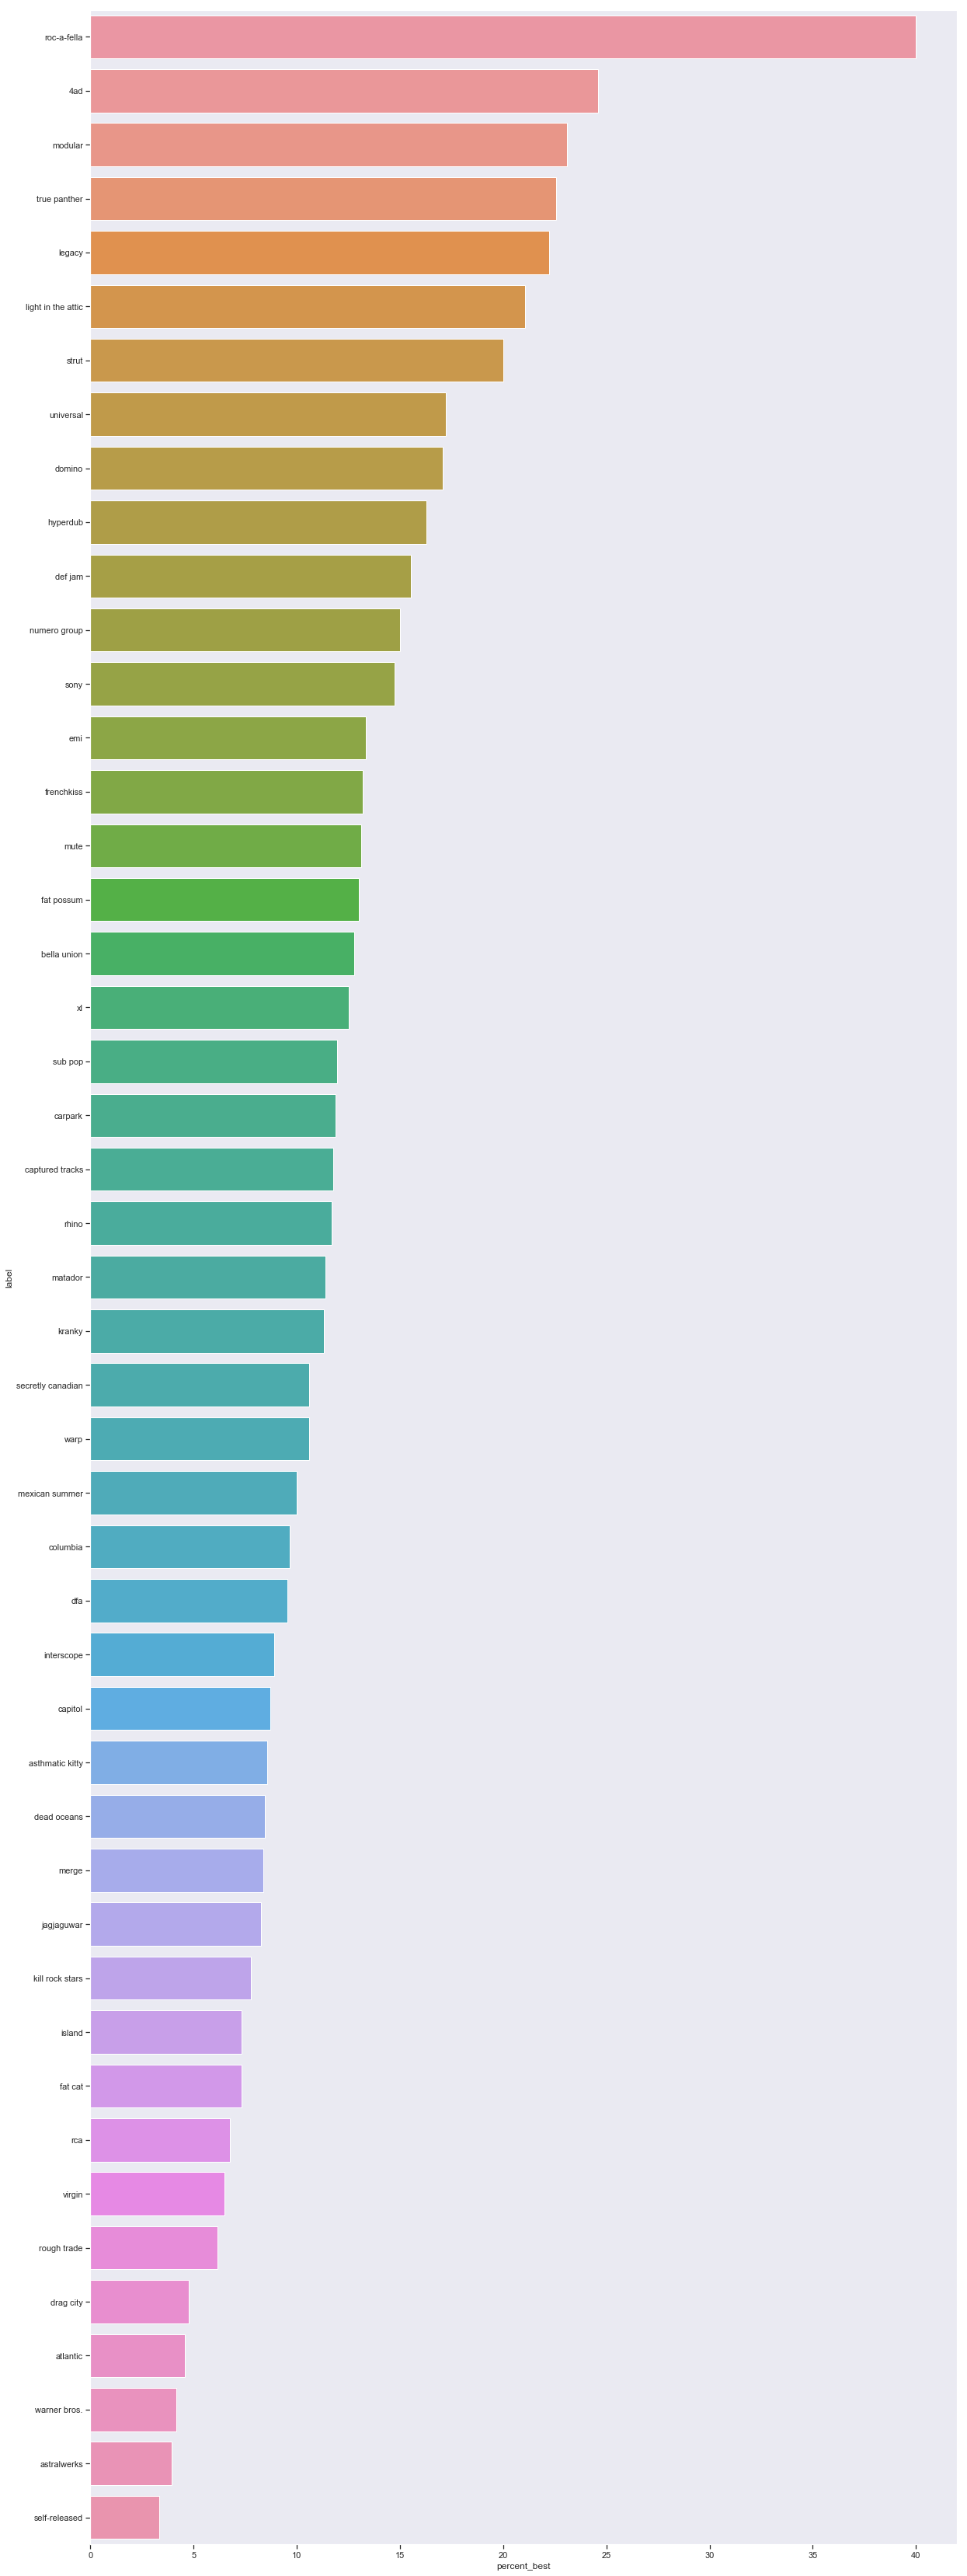

In [73]:
#look at distributions
f, x = plt.subplots(figsize=(20,60))
sns.barplot(x='percent_best', y='label', data=df_labels_most_best)
